# OSoMe + Botometer mashup
by [Clayton A Davis](http://www.clayadavis.net)
with updates by Emmi Bevensee

This notebook shows how to use the [OSoMe](http://osome.iuni.iu.edu/) (pronounced "awesome") and [Botometer](http://truthy.indiana.edu/botornot)(formerly BotOrNot) APIs together to achieve a task impossible with either alone.

To run this demo, you need some familiarity with the Python progamming language. To ensure access to all required packages, we encourage use of the [Anaconda](https://docs.continuum.io/anaconda/install) Python distribution. Your mileage with other Python distributions may vary. This code is provided as-is, and we do not have the resources to provide support.

In this demo, we will:

1. Given a set of Twitter hashtags and a date range, use OSoMe to retrieve the most active users in the conversation
2. Check these active users' bot scores with Botometer
3. Generate a distribution of bot scores like this one: ![example distribution](https://s3.amazonaws.com/clayadavis_public/active-users_election2016_2015-04-16_2015-04-28.png "Histogram and kernel density estimate")

## Dependencies

This notebook was written using Python >3.5 and tested for compatibility with Python 2.7. All Python dependencies are installable with `pip`. If you're using [Anaconda](https://docs.continuum.io/anaconda/install), you can probably just do

    conda install seaborn

and

    pip install botometer

from your command line.

Once these packages have been installed, run the next cell to import the required modules.

In [35]:
from __future__ import print_function, unicode_literals

import datetime
import json
import re
import time
import traceback

import botometer
import pandas as pd
%matplotlib inline
import requests
import seaborn as sns

import matplotlib.pyplot as plt

# 0. Enter authentication keys

We are going to use APIs for Twitter and Mashape, so you need accounts for both.

## 0.1 Twitter
To get Twitter API keys, you need to define an app at [apps.twitter.com](https://apps.twitter.com/) or use one you've previously created. If you're creating a new app, the name, URL, etc. don't matter to this demo. 

Go into the app's properties by clicking on it, and then click on the "Keys and Access Tokens" tab. Your API keys should be inside, as illustrated here: ![twitter api keys](https://s3.amazonaws.com/clayadavis_public/twitter_api_keys.jpg "Twitter API keys")

Copy your keys into the code below and execute the block.

In [36]:
#add your keys here
twitter_app_auth = {
    'consumer_key': 'COPY_CONSUMER_KEY_HERE',
    'consumer_secret': 'COPY_CONSUMER_SECRET_HERE',
    'access_token': 'COPY_ACCESS_TOKEN_HERE',
    'access_token_secret': 'COPY_ACCESS_TOKEN_SECRET_HERE',
  }

for api_key in twitter_app_auth.values(): 
    assert not api_key.startswith('COPY_')

## 0.2 Mashape

Once you have a Mashape account and are logged in, navigate to the [OSoMe API documentation](https://market.mashape.com/truthy/osome) and look at any of the examples on the right. Your key will be listed in the example request headers. Copy it into the code below and execute the block. Make sure not to include any closing quotation marks: ![mashape api key](https://s3.amazonaws.com/clayadavis_public/mashape_key.jpg "Mashape API key")

In [37]:
#add your key here
mashape_key = 'COPY_MASHAPE_KEY_HERE'

assert not mashape_key.startswith('COPY_')

# 1. Search OSoMe database using Mashape

Enter one or more hashtags you're interested in searching below. The # sign is required, but hashtags are case-insensitive.

Also enter the start and end dates for your search window. The more tweets returned by the search, the longer it takes to retrieve the result, so you may wish to start small (a few days). The maximum allowed date window is one month. If you exceed this amount your code will break. Focusing on recent (last few weeks) yields the best results.

Execute the block after entering your search parameters.

In [38]:
hashtags = ['#MAGA'] #This can be a list of hashtags
start_date = datetime.date(2019, 1, 23) # year, month, day
end_date   = datetime.date(2019, 1, 27)

for hashtag in hashtags:
    assert hashtag.startswith('#')

The following Mashape request to begin the query should only take a second. The returned "result_url" will be used later to fetch the query results.

In [39]:
mashape_method_url = 'https://osome-public.p.mashape.com/user-post-count'
params = {
    'q': ','.join(hashtags),
    'start': start_date.isoformat(),
    'end': end_date.isoformat(),
}

headers = {
    'X-Mashape-Key': mashape_key,
}

mashape_response = requests.get(mashape_method_url, params=params, headers=headers)
mashape_content = mashape_response.json()

print(json.dumps(mashape_content, indent=3, sort_keys=True))
result_url = mashape_content['result_url'] 
#if you get server errors, check the API support section in the OSoMe API on Mashape

{
   "job_id": "580e9352-905f-44d8-98eb-68d2667b647b",
   "result_url": "https://osome.iuni.iu.edu/moe/api/mashape/result/580e9352-905f-44d8-98eb-68d2667b647b"
}


Execute the following block to retrieve the result. Depending on the number of tweets returned by the query, this may take several minutes. While it's running, an asterisk (\*) will be displayed in the command number to the left of the block. If the block times out, just re-execute it. Once the query finishes, the result will be a file with a series of lines in this format:

```
<screen_name>(<user_id>)\t<number_of_tweets>
```

The first few lines of this result will be displayed below. We will later sort this list by number of tweets to get the most active users.

In [40]:
#if your date range is too long it may lead to a time-out here
#don't run next cells until this finishes
result_response = requests.get(result_url)
print(result_response.text[:255])

003a04f8c2054b7(2920659436)	1
007RedRover(989177513741078528)	1
007cigarjoe(1351095835)	1
007jorgeEnrique(923365296748064768)	1
00LovelyDay00(887998063)	1
00lOll0(3006912146)	2
00michaelroy(403085272)	1
01ProudAmerican(707753844516593665)	1
01_zebra(39130


We want a separate column for each screen name, user id, and the number of tweets from the most active users. Executing the next block will extract what we want using a regular expression and store the results in a a tabular data structure, sorted in descending order of tweet number.

After executing the block, the first few rows of the table will be displayed.

In [41]:
def extract_records(result_response):
    result_pattern = r'(\w+)\((\d+)\)\s+(\d+)'
    for line in result_response.text.split('\n'):
        match = re.match(result_pattern, line)
        if match:
            yield match.groups()

table = pd.DataFrame.from_records(extract_records(result_response),
                               columns=['screen_name', 'user_id', 'tweets'],
                               index=['user_id'],
                              )

# from_records doesn't do type inference, so the tweets column gets parsed as a string
table['tweets'] = table['tweets'].astype(int)
table = table.sort_values(by='tweets', ascending=False)

table.head()

,screen_name,tweets
user_id,,
1071181437603332099,Alpha_Omega_Yah,275
33658276,thebestcloser,115
1057778110307975168,DadeMurph,111
939120063315034114,ElectronicWar01,92
1017681558881423360,Fidelis42351561,84


# 2. Compute bot scores

First we need to do some setup. Execute the following block to initialize the BotOrNot API.

In [42]:
bon = botometer.Botometer(wait_on_ratelimit=True,
                          mashape_key=mashape_key,
                          **twitter_app_auth)

We also need to add a column to our table for the calculated bot scores. Since we don't have these bot scores yet, these will appear as `NaN` below.

In [43]:
table['bot_score'] = pd.np.nan
table.head()

,screen_name,tweets,bot_score
user_id,,,
1071181437603332099,Alpha_Omega_Yah,275,NaN
33658276,thebestcloser,115,NaN
1057778110307975168,DadeMurph,111,NaN
939120063315034114,ElectronicWar01,92,NaN
1017681558881423360,Fidelis42351561,84,NaN


We can check and make sure the BotOrNot API is working correctly by checking a known-human account. This will take a few seconds.

In [28]:
bon.check_account('@clayadavis')

{'cap': {'english': 0.0014828129117616376, 'universal': 0.0033536770167744536},
 'categories': {'content': 0.12470468567559924,
  'friend': 0.09994026911083925,
  'network': 0.08835149684131184,
  'sentiment': 0.1169582905663787,
  'temporal': 0.2884487682695764,
  'user': 0.05042452964186063},
 'display_scores': {'content': 0.6,
  'english': 0.2,
  'friend': 0.5,
  'network': 0.4,
  'sentiment': 0.6,
  'temporal': 1.4,
  'universal': 0.4,
  'user': 0.3},
 'scores': {'english': 0.03546593341354506, 'universal': 0.07651310672792835},
 'user': {'id_str': '1548959833', 'screen_name': 'clayadavis'}}

If that went smoothly, you will see a `'score'` field in the result. That is the bot score. Scores below 0.4 indicate human-like behavior and scores above 0.6 suggest bot-like behavior  although it does not guarentee that the user is fully-automated.

Next we will do the same for the most active accounts from the list above. The `num_users_to_score` parameter will control how many accounts we'll check per execution of the following block. Each calculation takes 5-10 seconds, so keep this number reasonable at first. Also keep in mind the rate limits of both Twitter and BotOrNot: 180 requests per 15-minute period.

Each execution of the following block will pick up where the previous execution left off; only `NaN` bot scores are updated. So feel free to interrupt execution and continue on if you get impatient, you can always come back and calculate more.

In [45]:
#you can change the number of users here but each one takes about 5 seconds
num_users_to_score = 30
unscored_rows = table[table['bot_score'].isnull()]
rows_to_score = unscored_rows[:num_users_to_score]

for num, (user_id, data) in enumerate(rows_to_score.iterrows()):
    print("Checking {current} of {total}, sn: {sn}, id: {uid}...".format(
           current=num+1,
           total=len(rows_to_score),
           sn=data['screen_name'],
           uid=user_id,
    ))
    retry = 0
    while True:
        try:
            bon_result = bon.check_account(user_id)
            #we've here selected the universal score rather than english specific but you can change this
            table.loc[user_id, 'bot_score'] = bon_result['scores']['universal']
            print('    ...success!')
        except botometer.tweepy.TweepError:
            print('    ...fail.')
        except requests.HTTPError:
            secs = 2 ** retry
            traceback.print_exc()
            print('    ...error. Retrying in %i secs...' % secs)
            retry += 1
        if 0 < retry <= 3:
            time.sleep(secs)
        else:
            break
print("Done checking %i accounts." % num_users_to_score)
            

Checking 1 of 30, sn: Alpha_Omega_Yah, id: 1071181437603332099...
    ...success!
Checking 2 of 30, sn: thebestcloser, id: 33658276...
    ...success!
Checking 3 of 30, sn: DadeMurph, id: 1057778110307975168...
    ...success!
Checking 4 of 30, sn: ElectronicWar01, id: 939120063315034114...
    ...success!
Checking 5 of 30, sn: Fidelis42351561, id: 1017681558881423360...
    ...success!
Checking 6 of 30, sn: starlowell, id: 3229496760...
    ...success!
Checking 7 of 30, sn: SealeyGerald, id: 1028366243601018881...
    ...success!
Checking 8 of 30, sn: Tombx7M, id: 877699334...
    ...success!
Checking 9 of 30, sn: actlightning, id: 15170286...
    ...success!
Checking 10 of 30, sn: HookedOnHopium, id: 803645786114269184...
    ...success!
Checking 11 of 30, sn: ZnaTrainer, id: 13817822...
    ...success!
Checking 12 of 30, sn: mdwehbie, id: 94207009...
    ...success!
Checking 13 of 30, sn: iamtheMAGAbot, id: 871794289726148610...
    ...success!
Checking 14 of 30, sn: t_r_u_m_p_i_n_g

Executing the next block will display the top N accounts, sorted by number of tweets, with bot scores filled in.

In [46]:
table.head(30)

,screen_name,tweets,bot_score
user_id,,,
1071181437603332099,Alpha_Omega_Yah,275,0.283782
33658276,thebestcloser,115,0.374267
1057778110307975168,DadeMurph,111,0.799058
939120063315034114,ElectronicWar01,92,0.576809
1017681558881423360,Fidelis42351561,84,0.355186
3229496760,starlowell,67,0.635707
1028366243601018881,SealeyGerald,63,0.884865
877699334,Tombx7M,47,0.596776
15170286,actlightning,42,0.474489


Some of the bot scores may still be `NaN` if the account was deleted or blocked and we could not obtain a bot score; this is normal. 

The next block will create a histogram and its [kernel density estimate](https://en.wikipedia.org/wiki/Kernel_density_estimation) from the available bot scores, and save the image as a png in the current directory.

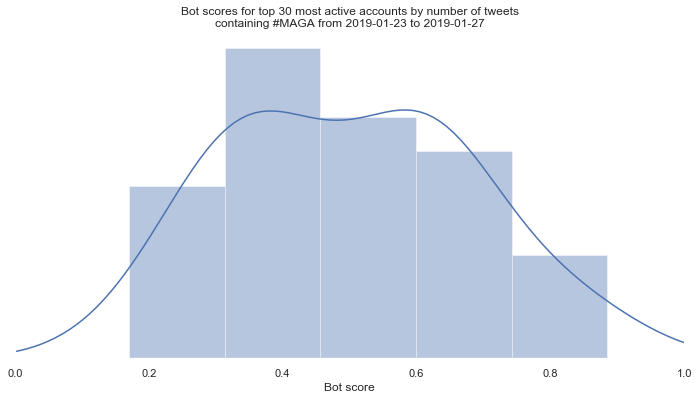

In [49]:
bot_scores = table[table['bot_score'].notnull()]['bot_score']
sns.set(rc={"figure.figsize": (12, 6)})
ax = sns.distplot(bot_scores)
ax.set_title('Bot scores for top {N} most active accounts by number of tweets'
             '\ncontaining {hashtags} from {start} to {end}'.format(
    N=len(bot_scores),
    hashtags=', '.join(hashtags),
    start=start_date.isoformat(),
    end=end_date.isoformat(),
    ))
ax.set_xlim([0,1])
ax.set_xlabel('Bot score')
ax.yaxis.set_visible(False)
ax.patch.set_visible(False)
safe_hashtag_list = ','.join(hashtags).replace('#', '')
filename = '_'.join(['active-users', safe_hashtag_list, start_date.isoformat(), end_date.isoformat()])
#saves image to your local folder
plt.savefig(filename)
#If you get a FutureWarning message about Anaconda, ignore it

Of course we can calculate any statistics we want of this series. Executing the following will print the mean and median of this distribution.

In [48]:
print("Mean: %0.2f, median: %0.2f" % (bot_scores.mean(), bot_scores.median()))

Mean: 0.50, median: 0.50


And that's it! This approach of chaining together APIs is extremely powerful, and there are many other combinations possible with the two APIs used here. Please tweet at [@TruthyAtIndiana](http://twitter.com/TruthyAtIndiana) or me ([@clayadavis](http://twitter.com/clayadavis)) if you found this mashup useful. 